In [1]:
# Map new data to hypoMap using scVI 

In [2]:
# Please download the model from https://github.com/lsteuernagel/mapscvi/tree/master/inst/extdata/models/hypoMap_harmonized_scVI_model
# and the hypoMap anndata from: https://keeper.mpdl.mpg.de/d/1d250b01f5604aad99fc/
# also from cellxgene (but currently lacking the scvi embedding): https://cellxgene.cziscience.com/collections/d86517f0-fa7e-4266-b82e-a521350d6d36
# the example query object can be found at https://github.com/lsteuernagel/mapscvi/tree/master/inst 

In [36]:
# Copy the files to your local file system and change the filepaths accordingly
# model path (included in mapscvi R package)
model_path = "/beegfs/scratch/bruening_scratch/lsteuernagel/projects/mapscvi/inst/extdata/models/hypoMap_harmonized_scVI_model/"
# specify or load your anndata / the example is available from the R package)
file_query = "/beegfs/scratch/bruening_scratch/lsteuernagel/projects/mapscvi/inst/python_notebook/query_romanov.h5ad"
# hypomap reference from cellxgene
file_reference = "/beegfs/scratch/bruening_scratch/lsteuernagel/data/hypoMap_publication/hypoMap_cellxgene.h5ad"

In [2]:
# load scvi
# see here for an introduction: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scarches_scvi_tools.html
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import anndata
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 12345

Global seed set to 0
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
Global seed set to 12345


In [37]:
# load query data
adata_query = sc.read(file_query)

In [17]:
# load the hypomap reference anndata
adata_hypomap = sc.read(file_reference)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


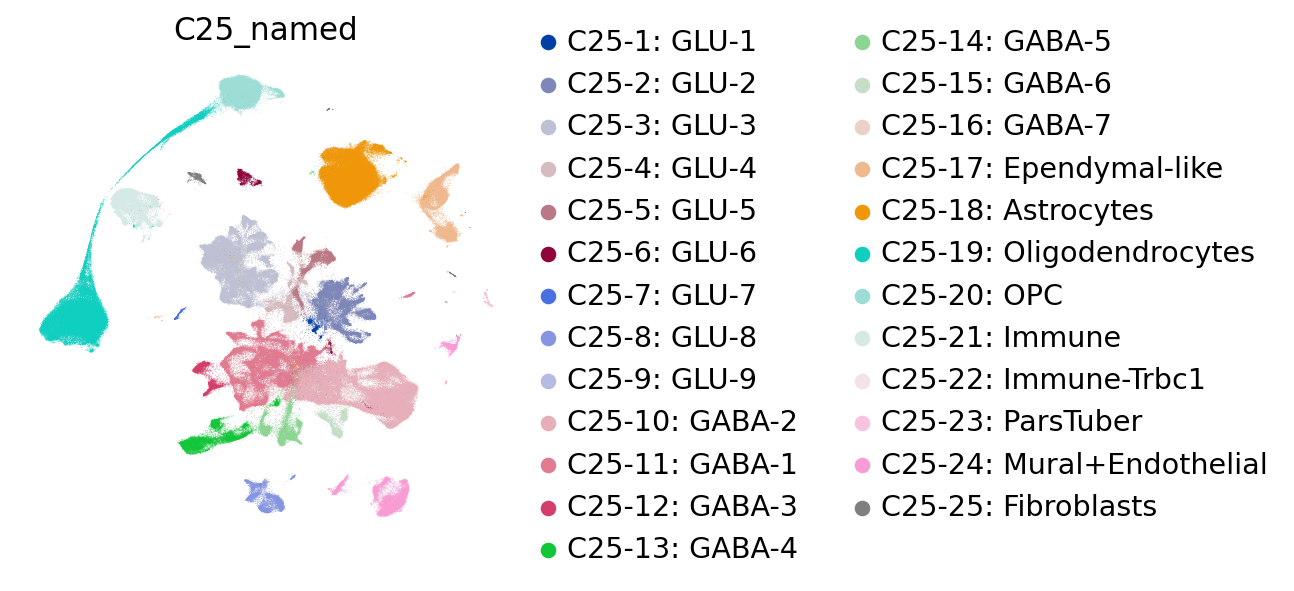

In [19]:
# plot the general hypomap UMAP
sc.pl.umap(
    adata_hypomap,
    color=["C25_named"],
    frameon=False,
    ncols=1,
)

In [39]:
# the model requires Batch_ID as variable, we just add all data as one batch
adata_query.obs['Batch_ID'] = "romanov_batch_1"

In [38]:
# this is how we can access the highly variable features of the model
vars = scvi.model.SCVI.prepare_query_anndata(adata_query, model_path,return_reference_var_names = True)
vars

INFO     File                                                                                                      
         /beegfs/scratch/bruening_scratch/lsteuernagel/projects/mapscvi/inst/extdata/models/hypoMap_harmonized_scVI
         _model/model.pt already downloaded                                                                        


Index(['Avp', 'Sst', 'Trh', 'Pomc', 'Npy', 'Hcrt', 'Gal', 'Oxt', 'Pmch',
       'Cartpt',
       ...
       'Gm35611', 'Mob3b', 'Gm49708', 'Il2rg', 'Cbs', 'Fam20a', 'Gabra4',
       'Cpd', 'Rgs12', 'Rras'],
      dtype='object', length=3000)

In [41]:
# scvi expects un-normalized counts: move the raw counts to .X
adata_query.X = adata_query.raw.X

In [42]:
# prepare query data for online training
scvi.model.SCVI.prepare_query_anndata(adata_query, model_path)

INFO     File                                                                                                      
         /beegfs/scratch/bruening_scratch/lsteuernagel/projects/mapscvi/inst/extdata/models/hypoMap_harmonized_scVI
         _model/model.pt already downloaded                                                                        
INFO     Found 89.9% reference vars in query data.                                                                 


/opt/conda/lib/python3.10/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [43]:
# create the new query model instance.
vae_query = scvi.model.SCVI.load_query_data(
    adata_query,
    model_path
)

INFO     File                                                                                                      
         /beegfs/scratch/bruening_scratch/lsteuernagel/projects/mapscvi/inst/extdata/models/hypoMap_harmonized_scVI
         _model/model.pt already downloaded                                                                        


In [44]:
# train, potentially increase max_epochs
vae_query.train(max_epochs=20, plan_kwargs=dict(weight_decay=0.0))
adata_query.obsm["X_scVI"] = vae_query.get_latent_representation()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 20/20: 100%|██████| 20/20 [00:10<00:00,  2.03it/s, loss=1.42e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████| 20/20 [00:10<00:00,  1.95it/s, loss=1.42e+03, v_num=1]


In [45]:
## calculate UMAP based on hypoMAP:
sc.pp.neighbors(adata_query, use_rep="X_scVI")
sc.tl.leiden(adata_query)
sc.tl.umap(adata_query)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


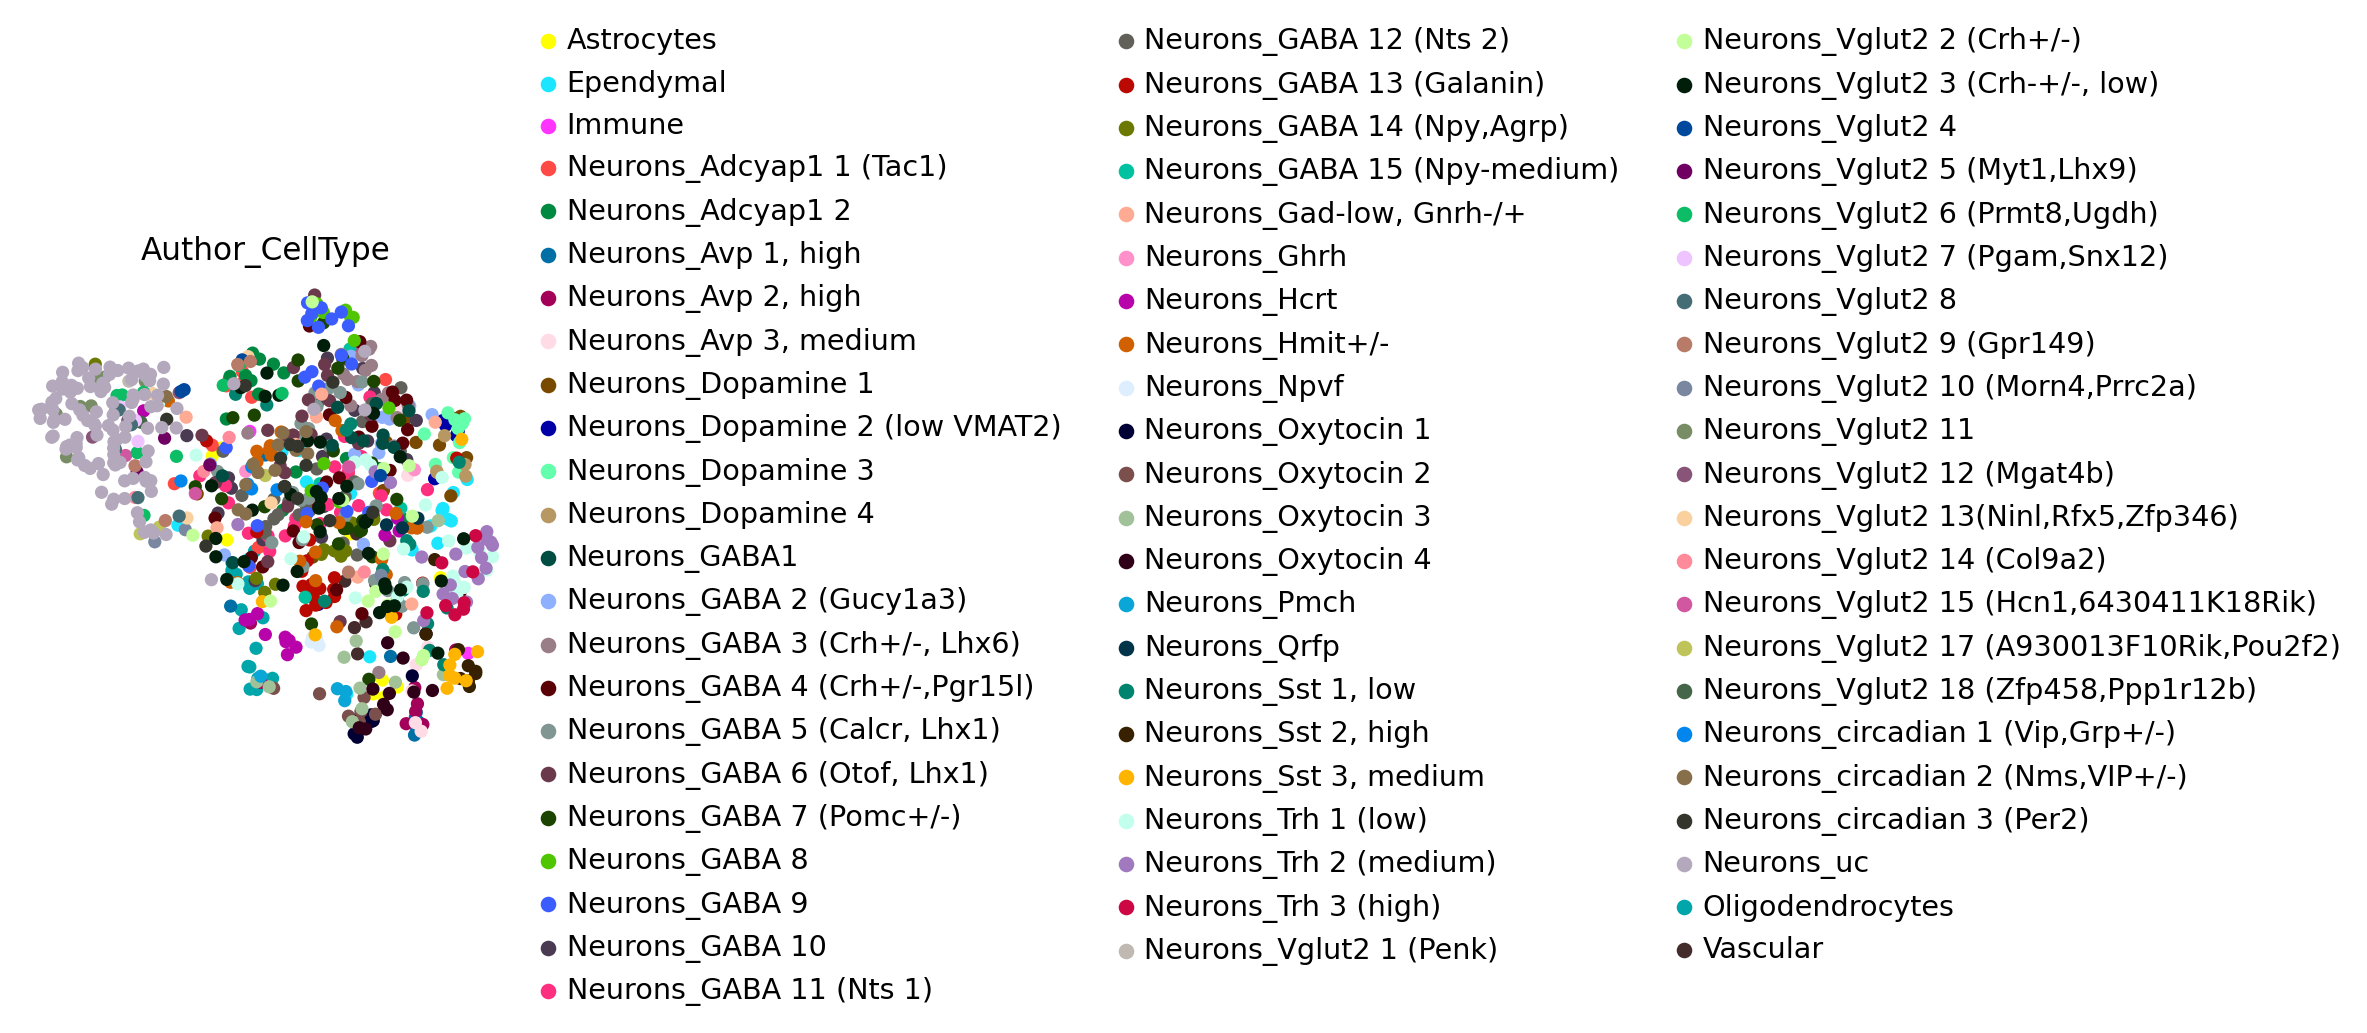

In [47]:
# plot UMAP
sc.pl.umap(
    adata_query,
    color=["Author_CellType"],
    frameon=False,
    ncols=1,
)

In [ ]:
# See here for an example for label propagation in scvi: https://docs.scvi-tools.org/en/1.0.1/tutorials/notebooks/query_hlca_knn.html